In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Training")
categories = []
for filename in filenames:
    category = filename[0]
    if category == "3":
        categories.append("triangle")
    elif category == "4":
        categories.append("square")
    elif category == "5":
        categories.append("pentagon")
    elif category == "6":
        categories.append("hexagon")
    elif category == "7":
        categories.append("heptagon")
    elif category == "8":
        categories.append("octagon")
    elif category == "9":
        categories.append("nonagon")
    else:
        categories.append("decagon")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

#This line used to shuffle the dataset
df = df.sample(frac=1)


In [4]:
df.to_csv(r"C:\Users\nguyent2\Desktop\New.csv")
df.head()

,filename,category
51512,7_sides_2359.png,heptagon
74093,9_sides_4682.png,nonagon
23752,4_sides_4375.png,square
1659,10_sides_2491.png,decagon
76846,9_sides_716.png,nonagon


In [5]:
df.tail()

,filename,category
5630,10_sides_6065.png,decagon
52505,7_sides_3252.png,heptagon
418,10_sides_1374.png,decagon
1599,10_sides_2437.png,decagon
53419,7_sides_4075.png,heptagon


<AxesSubplot:>

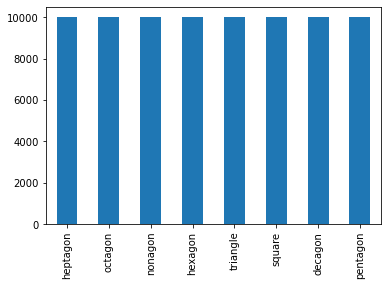

In [6]:
df['category'].value_counts().plot.bar()

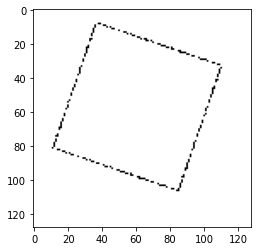

In [7]:
sample = random.choice(filenames)
image = load_img(r"C:\Users\nguyent2\Desktop\Training\\" + sample)
plt.imshow(image)

In [8]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

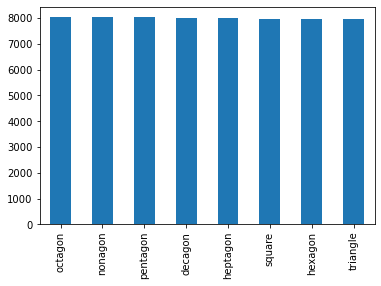

In [9]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

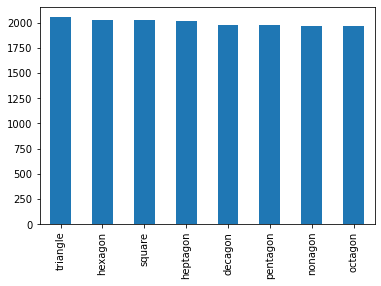

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size= batch_size
)

Found 64000 validated image filenames belonging to 8 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 16000 validated image filenames belonging to 8 classes.


In [14]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,   r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [15]:
plt.figure(figsize=(128, 128))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[early_stop]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
4266/4266 [==============================] - 674s 158ms/step - loss: 0.3814 - accuracy: 0.8748 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 2/50
4266/4266 [==============================] - 597s 140ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 3/50
4266/4266 [==============================] - 569s 133ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 4/50
4266/4266 [==============================] - 567s 133ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750


In [20]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

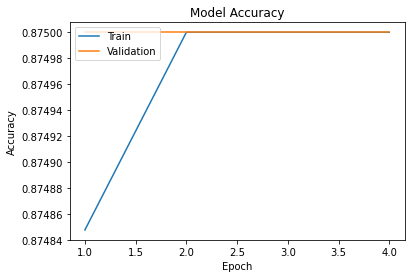

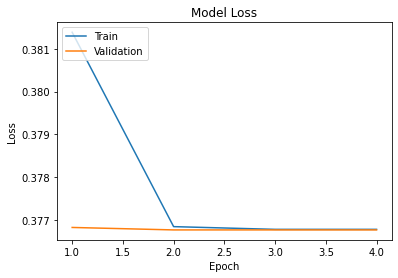

In [22]:
plotLearningCurve(history,4)

In [23]:
test_filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Testing")

test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [24]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\nguyent2\Desktop\Testing", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 80000 validated image filenames.


In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [26]:
test_df['category'] = np.argmax(predict, axis=-1)

In [27]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

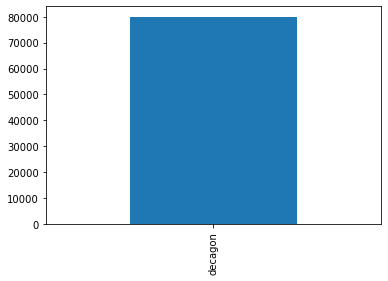

In [28]:
test_df['category'].value_counts().plot.bar()

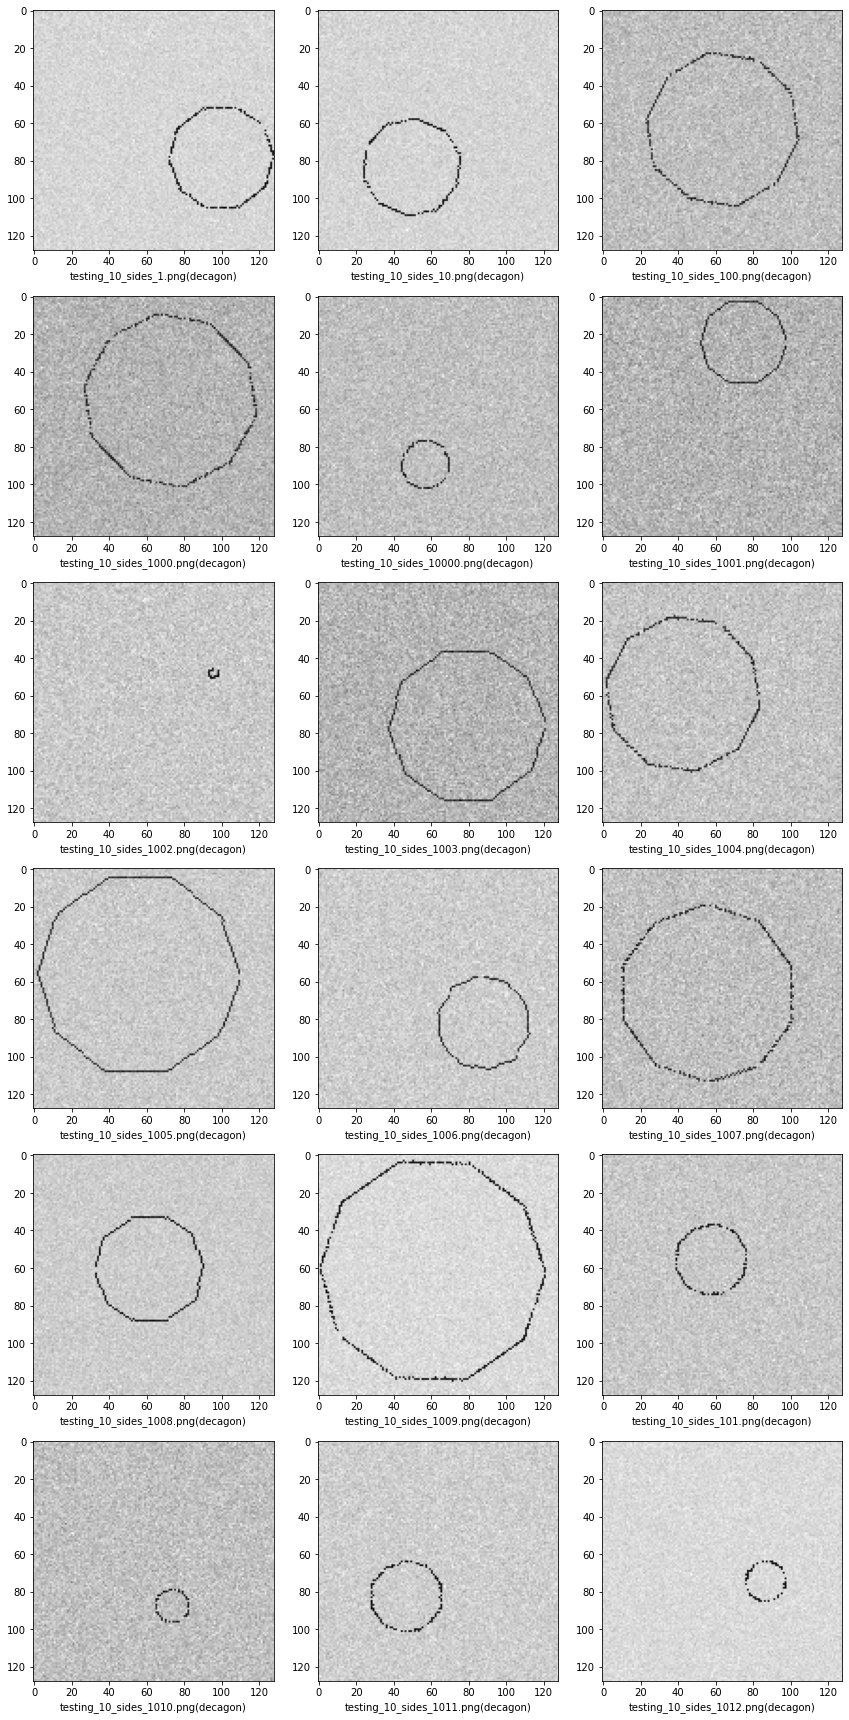

In [29]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\nguyent2\Desktop\Testing\\"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()